In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix

from collections import defaultdict

## Dataset

In [ ]:
# Define column names for your data
input_columns = ["X", "Y", "Z", "X+Y", "X2+Y2", "XY/Z", "Vertical", "Horizontal", "Inclination", "Azimuth", "WHT"]
output_columns = ["Supercritical", "Gas", "Liquid", "Dense", "Solid"]

In [ ]:
rootdir = '/content/drive/MyDrive/KIGAM/2023/OLGA_CO2INJ'
datadir = os.path.join(rootdir, 'data')

In [ ]:
# Load your CSV file into a DataFrame with the specified column names
data = pd.read_csv(f'{datadir}/All_OLGA_Final_Data_Filt.csv', names=input_columns + output_columns, header=None)
data.head(5)

,X,Y,Z,X+Y,X2+Y2,XY/Z,Vertical,Horizontal,Inclination,Azimuth,WHT,Supercritical,Gas,Liquid,Dense,Solid
0,1677.5,141.190,3373.6,1818.7,2834000.0,70.205,3388.4,1620.3,38.416,239.40,-20,1,0,0,0,0
1,3316.9,467.020,3205.9,3783.9,11220000.0,483.180,3282.0,3137.8,54.565,212.83,-20,1,0,0,0,0
2,3255.7,108.650,3365.4,3364.4,10612000.0,105.110,3410.6,3177.7,50.097,155.06,-20,1,0,0,0,0
3,3248.2,273.180,3359.5,3521.4,10625000.0,264.120,3276.6,3312.1,52.158,217.32,-20,1,0,0,0,0
4,3273.1,62.601,3374.4,3335.7,10717000.0,60.722,3271.1,3328.3,50.972,225.63,-20,1,0,0,0,0


In [ ]:
input_data = data[input_columns]
input_data.head(5)

,X,Y,Z,X+Y,X2+Y2,XY/Z,Vertical,Horizontal,Inclination,Azimuth,WHT
0,1677.5,141.190,3373.6,1818.7,2834000.0,70.205,3388.4,1620.3,38.416,239.40,-20
1,3316.9,467.020,3205.9,3783.9,11220000.0,483.180,3282.0,3137.8,54.565,212.83,-20
2,3255.7,108.650,3365.4,3364.4,10612000.0,105.110,3410.6,3177.7,50.097,155.06,-20
3,3248.2,273.180,3359.5,3521.4,10625000.0,264.120,3276.6,3312.1,52.158,217.32,-20
4,3273.1,62.601,3374.4,3335.7,10717000.0,60.722,3271.1,3328.3,50.972,225.63,-20


In [ ]:
input_data['WHT'].unique()

array([-20, -10,   0,  10,  20])

In [ ]:
co2_phase = data[output_columns]
co2_phase.head(5)

,Supercritical,Gas,Liquid,Dense,Solid
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [ ]:
co2_phase.nunique()

Supercritical    2
Gas              1
Liquid           1
Dense            2
Solid            1
dtype: int64

In [ ]:
#output_columns = ["Supercritical", "Gas", "Liquid", "Dense"]
output_columns = ["Supercritical", "Dense"]
co2_phase = co2_phase[output_columns]
co2_phase.head()

,Supercritical,Dense
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


### Discretize (bin)

In [ ]:
input_data.nunique()

X              21977
Y              33338
Z              19475
X+Y            23403
X2+Y2          30408
XY/Z           34134
Vertical       18706
Horizontal     20828
Inclination    25249
Azimuth        21700
WHT                5
dtype: int64

In [ ]:
num_bins = 50

In [ ]:
input_discretize_data = input_data.copy()
for col in ["X", "Y", "Z", "X+Y", "X2+Y2", "XY/Z", "Vertical", "Horizontal", "Inclination", "Azimuth"]:
    input_discretize_data[f'{col}_bin'] = pd.cut(input_data[col], num_bins, labels=[f'{col}_{i}' for i in range(num_bins)])
input_discretize_data = input_discretize_data.drop(labels=input_columns, axis=1)
input_discretize_data.head(5)

,X_bin,Y_bin,Z_bin,X+Y_bin,X2+Y2_bin,XY/Z_bin,Vertical_bin,Horizontal_bin,Inclination_bin,Azimuth_bin
0,X_13,Y_4,Z_28,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_12,Horizontal_6,Inclination_21,Azimuth_34
1,X_26,Y_16,Z_27,X+Y_27,X2+Y2_14,XY/Z_2,Vertical_11,Horizontal_11,Inclination_29,Azimuth_30
2,X_25,Y_3,Z_28,X+Y_24,X2+Y2_13,XY/Z_0,Vertical_12,Horizontal_11,Inclination_27,Azimuth_22
3,X_25,Y_9,Z_28,X+Y_25,X2+Y2_13,XY/Z_1,Vertical_11,Horizontal_12,Inclination_28,Azimuth_31
4,X_25,Y_2,Z_28,X+Y_24,X2+Y2_13,XY/Z_0,Vertical_11,Horizontal_12,Inclination_27,Azimuth_32


In [ ]:
for col in ["X", "Y", "Z", "X+Y", "X2+Y2", "XY/Z", "Vertical", "Horizontal", "Inclination", "Azimuth"]:
    print(input_discretize_data[f'{col}_bin'].value_counts())

X_24    23530
X_25    17239
X_12    16290
X_11    14314
X_13    13748
X_23     9829
X_26     9487
X_10     9398
X_14     8709
X_9      6751
X_15     6631
X_16     5899
X_8      5836
X_18     5686
X_19     5153
X_17     5141
X_7      4814
X_20     4123
X_6      3593
X_27     3362
X_22     3290
X_0      3190
X_21     3081
X_5      2053
X_28     1785
X_1      1348
X_4      1098
X_29     1009
X_3       922
X_2       884
X_30      748
X_31      635
X_32      445
X_37      307
X_33      294
X_36      289
X_34      283
X_38      279
X_35      233
X_39      137
X_40      110
X_42      110
X_41       94
X_44       55
X_45       49
X_43       40
X_46       35
X_47       25
X_48       15
X_49       10
Name: X_bin, dtype: int64
Y_0     34508
Y_1     29999
Y_2     18950
Y_3     18081
Y_4     15111
Y_5     12702
Y_6     11210
Y_7      9545
Y_8      9209
Y_9      8658
Y_10     6046
Y_11     4944
Y_12     3986
Y_13     3464
Y_14     2725
Y_15     2251
Y_16     1951
Y_17     1520
Y_18     1289
Y_19    

In [ ]:
input_discretize_data = pd.concat([input_discretize_data, input_data['WHT']], axis=1)
input_discretize_data.head(5)

,X_bin,Y_bin,Z_bin,X+Y_bin,X2+Y2_bin,XY/Z_bin,Vertical_bin,Horizontal_bin,Inclination_bin,Azimuth_bin,WHT
0,X_13,Y_4,Z_28,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_12,Horizontal_6,Inclination_21,Azimuth_34,-20
1,X_26,Y_16,Z_27,X+Y_27,X2+Y2_14,XY/Z_2,Vertical_11,Horizontal_11,Inclination_29,Azimuth_30,-20
2,X_25,Y_3,Z_28,X+Y_24,X2+Y2_13,XY/Z_0,Vertical_12,Horizontal_11,Inclination_27,Azimuth_22,-20
3,X_25,Y_9,Z_28,X+Y_25,X2+Y2_13,XY/Z_1,Vertical_11,Horizontal_12,Inclination_28,Azimuth_31,-20
4,X_25,Y_2,Z_28,X+Y_24,X2+Y2_13,XY/Z_0,Vertical_11,Horizontal_12,Inclination_27,Azimuth_32,-20


### Augmentation

In [ ]:
# Split the data into training and test sets (adjust the test_size and random_state)
total_length = input_discretize_data.shape[0]
train_indices, test_indices, _, _ = train_test_split(np.arange(total_length), np.arange(total_length), test_size=0.2, random_state=42)
train_indices, val_indices, _, _ = train_test_split(np.arange(len(train_indices)), np.arange(len(train_indices)), test_size=0.1, random_state=0)
print(f'Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}')

Train: 145717, Val: 16191, Test: 40478


In [ ]:
total_input_output_data = pd.concat([input_discretize_data, co2_phase], axis=1)
train_input_output_data = total_input_output_data.iloc[train_indices]
train_input_output_data.head(5)

,X_bin,Y_bin,Z_bin,X+Y_bin,X2+Y2_bin,XY/Z_bin,Vertical_bin,Horizontal_bin,Inclination_bin,Azimuth_bin,WHT,Supercritical,Dense
128874,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,10,1,0
93438,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,0,0,1
96468,X_9,Y_2,Z_12,X+Y_9,X2+Y2_1,XY/Z_0,Vertical_5,Horizontal_4,Inclination_25,Azimuth_21,0,0,1
48509,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-10,1,0
87656,X_12,Y_0,Z_27,X+Y_11,X2+Y2_3,XY/Z_0,Vertical_11,Horizontal_6,Inclination_24,Azimuth_27,0,1,0


Exclude validation and test data

In [ ]:
val_input_output_data = total_input_output_data.iloc[val_indices]
val_x = val_input_output_data.iloc[:,:11]
val_y = val_input_output_data.iloc[:,11:]

In [ ]:
test_input_output_data = total_input_output_data.iloc[test_indices]
test_x = test_input_output_data.iloc[:,:11]
test_y = test_input_output_data.iloc[:,11:]

In [ ]:
temp_stride = 2

In [ ]:
wht_values = input_data['WHT'].unique()
aug_wht_values = np.arange(np.min(wht_values), np.max(wht_values)+1, temp_stride)
aug_wht_values

array([-20, -18, -16, -14, -12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,
         6,   8,  10,  12,  14,  16,  18,  20])

### Supercritical augmentation:
- Larger or equal WHT with the given and same well geometry

In [ ]:
def sc_aug(wht_value):
    return [w_v for w_v in aug_wht_values if w_v >= wht_value]

In [ ]:
sc_train_input_output_data = train_input_output_data[train_input_output_data['Supercritical']==1]
sc_train_input_output_data.head(5)

,X_bin,Y_bin,Z_bin,X+Y_bin,X2+Y2_bin,XY/Z_bin,Vertical_bin,Horizontal_bin,Inclination_bin,Azimuth_bin,WHT,Supercritical,Dense
128874,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,10,1,0
48509,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-10,1,0
87656,X_12,Y_0,Z_27,X+Y_11,X2+Y2_3,XY/Z_0,Vertical_11,Horizontal_6,Inclination_24,Azimuth_27,0,1,0
142370,X_13,Y_0,Z_22,X+Y_12,X2+Y2_3,XY/Z_0,Vertical_9,Horizontal_6,Inclination_24,Azimuth_1,10,1,0
10316,X_23,Y_6,Z_27,X+Y_22,X2+Y2_10,XY/Z_0,Vertical_11,Horizontal_11,Inclination_26,Azimuth_22,-20,1,0


In [ ]:
sc_train_aug_input_output_data = sc_train_input_output_data.assign(WHT=sc_train_input_output_data['WHT'].map(sc_aug)).explode('WHT')
sc_train_aug_input_output_data = sc_train_aug_input_output_data.reset_index(drop=True)
sc_train_aug_input_output_data.head(10)

,X_bin,Y_bin,Z_bin,X+Y_bin,X2+Y2_bin,XY/Z_bin,Vertical_bin,Horizontal_bin,Inclination_bin,Azimuth_bin,WHT,Supercritical,Dense
0,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,10,1,0
1,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,12,1,0
2,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,14,1,0
3,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,16,1,0
4,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,18,1,0
5,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,20,1,0
6,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-10,1,0
7,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-8,1,0
8,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-6,1,0
9,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-4,1,0


In [ ]:
print(f'Before SC aug: {sc_train_input_output_data.shape[0]}, After SC aug: {sc_train_aug_input_output_data.shape[0]}')

Before SC aug: 91065, After SC aug: 1107115


Drop duplicates from val

In [ ]:
merged_train_val = pd.merge(sc_train_aug_input_output_data, val_input_output_data, how='left', indicator=True)
sc_train_aug_input_output_data = merged_train_val[merged_train_val['_merge']=='left_only']
sc_train_aug_input_output_data = sc_train_aug_input_output_data.drop(columns=['_merge'], inplace=False)
sc_train_aug_input_output_data.head(10)

,X_bin,Y_bin,Z_bin,X+Y_bin,X2+Y2_bin,XY/Z_bin,Vertical_bin,Horizontal_bin,Inclination_bin,Azimuth_bin,WHT,Supercritical,Dense
0,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,10,1,0
1,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,12,1,0
2,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,14,1,0
3,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,16,1,0
4,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,18,1,0
5,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,20,1,0
6,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-10,1,0
7,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-8,1,0
8,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-6,1,0
9,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-4,1,0


Drop duplicates from test

In [ ]:
merged_train_test = pd.merge(sc_train_aug_input_output_data, test_input_output_data, how='left', indicator=True)
sc_train_aug_input_output_data = merged_train_test[merged_train_test['_merge']=='left_only']
sc_train_aug_input_output_data = sc_train_aug_input_output_data.drop(columns=['_merge'], inplace=False)
sc_train_aug_input_output_data.head(10)

,X_bin,Y_bin,Z_bin,X+Y_bin,X2+Y2_bin,XY/Z_bin,Vertical_bin,Horizontal_bin,Inclination_bin,Azimuth_bin,WHT,Supercritical,Dense
1,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,12,1,0
2,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,14,1,0
3,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,16,1,0
4,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,18,1,0
6,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-10,1,0
7,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-8,1,0
8,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-6,1,0
9,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-4,1,0
10,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-2,1,0
12,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,2,1,0


In [ ]:
print(f'Before SC aug: {sc_train_input_output_data.shape[0]}, After SC aug and drop: {sc_train_aug_input_output_data.shape[0]}')

Before SC aug: 91065, After SC aug and drop: 1035951


### Dense augmentation:
- Lower or equal WHT with the given and same well geometry

In [ ]:
def dense_aug(wht_value):
    return [d_v for d_v in aug_wht_values if d_v <= wht_value]

In [ ]:
dense_train_input_output_data = train_input_output_data[train_input_output_data['Dense']==1]
dense_train_input_output_data.head(5)

,X_bin,Y_bin,Z_bin,X+Y_bin,X2+Y2_bin,XY/Z_bin,Vertical_bin,Horizontal_bin,Inclination_bin,Azimuth_bin,WHT,Supercritical,Dense
93438,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,0,0,1
96468,X_9,Y_2,Z_12,X+Y_9,X2+Y2_1,XY/Z_0,Vertical_5,Horizontal_4,Inclination_25,Azimuth_21,0,0,1
93911,X_8,Y_4,Z_17,X+Y_8,X2+Y2_1,XY/Z_0,Vertical_7,Horizontal_3,Inclination_19,Azimuth_26,0,0,1
110132,X_0,Y_0,Z_19,X+Y_0,X2+Y2_0,XY/Z_0,Vertical_4,Horizontal_3,Inclination_1,Azimuth_26,0,0,1
71157,X_13,Y_2,Z_15,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_3,Horizontal_9,Inclination_29,Azimuth_26,-10,0,1


In [ ]:
dense_train_aug_input_output_data = dense_train_input_output_data.assign(WHT=dense_train_input_output_data['WHT'].map(dense_aug)).explode('WHT')
dense_train_aug_input_output_data.head(10)

,X_bin,Y_bin,Z_bin,X+Y_bin,X2+Y2_bin,XY/Z_bin,Vertical_bin,Horizontal_bin,Inclination_bin,Azimuth_bin,WHT,Supercritical,Dense
93438,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-20,0,1
93438,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-18,0,1
93438,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-16,0,1
93438,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-14,0,1
93438,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-12,0,1
93438,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-10,0,1
93438,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-8,0,1
93438,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-6,0,1
93438,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-4,0,1
93438,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-2,0,1


In [ ]:
print(f'Before Dense aug: {dense_train_input_output_data.shape[0]}, After Dense aug: {dense_train_aug_input_output_data.shape[0]}')

Before Dense aug: 54652, After Dense aug: 335792


Drop duplicates from val

In [ ]:
merged_train_val = pd.merge(dense_train_aug_input_output_data, val_input_output_data, how='left', indicator=True)
dense_train_aug_input_output_data = merged_train_val[merged_train_val['_merge']=='left_only']
dense_train_aug_input_output_data = dense_train_aug_input_output_data.drop(columns=['_merge'], inplace=False)
dense_train_aug_input_output_data.head(10)

,X_bin,Y_bin,Z_bin,X+Y_bin,X2+Y2_bin,XY/Z_bin,Vertical_bin,Horizontal_bin,Inclination_bin,Azimuth_bin,WHT,Supercritical,Dense
1,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-18,0,1
2,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-16,0,1
3,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-14,0,1
4,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-12,0,1
6,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-8,0,1
7,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-6,0,1
8,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-4,0,1
9,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-2,0,1
10,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,0,0,1
11,X_9,Y_2,Z_12,X+Y_9,X2+Y2_1,XY/Z_0,Vertical_5,Horizontal_4,Inclination_25,Azimuth_21,-20,0,1


Drop duplicates from test

In [ ]:
merged_train_test = pd.merge(dense_train_aug_input_output_data, test_input_output_data, how='left', indicator=True)
dense_train_aug_input_output_data = merged_train_test[merged_train_test['_merge']=='left_only']
dense_train_aug_input_output_data = dense_train_aug_input_output_data.drop(columns=['_merge'], inplace=False)
dense_train_aug_input_output_data.head(10)

,X_bin,Y_bin,Z_bin,X+Y_bin,X2+Y2_bin,XY/Z_bin,Vertical_bin,Horizontal_bin,Inclination_bin,Azimuth_bin,WHT,Supercritical,Dense
0,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-18,0,1
1,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-16,0,1
2,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-14,0,1
3,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-12,0,1
4,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-8,0,1
5,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-6,0,1
6,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-4,0,1
7,X_8,Y_0,Z_20,X+Y_7,X2+Y2_1,XY/Z_0,Vertical_9,Horizontal_3,Inclination_18,Azimuth_30,-2,0,1
9,X_9,Y_2,Z_12,X+Y_9,X2+Y2_1,XY/Z_0,Vertical_5,Horizontal_4,Inclination_25,Azimuth_21,-20,0,1
10,X_9,Y_2,Z_12,X+Y_9,X2+Y2_1,XY/Z_0,Vertical_5,Horizontal_4,Inclination_25,Azimuth_21,-18,0,1


In [ ]:
print(f'Before Dense aug: {dense_train_input_output_data.shape[0]}, After Dense aug and drop: {dense_train_aug_input_output_data.shape[0]}')

Before Dense aug: 54652, After Dense aug and drop: 309030


### Concat supercritical aug and dense aug

In [ ]:
train_aug_input_output_data = pd.concat([sc_train_aug_input_output_data, dense_train_aug_input_output_data], axis=0)
train_aug_input_output_data.head(5)

,X_bin,Y_bin,Z_bin,X+Y_bin,X2+Y2_bin,XY/Z_bin,Vertical_bin,Horizontal_bin,Inclination_bin,Azimuth_bin,WHT,Supercritical,Dense
1,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,12,1,0
2,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,14,1,0
3,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,16,1,0
4,X_24,Y_4,Z_25,X+Y_23,X2+Y2_12,XY/Z_0,Vertical_11,Horizontal_10,Inclination_29,Azimuth_23,18,1,0
6,X_13,Y_1,Z_25,X+Y_13,X2+Y2_3,XY/Z_0,Vertical_10,Horizontal_6,Inclination_27,Azimuth_22,-10,1,0


In [ ]:
print(f'Before augmentation: {train_input_output_data.shape[0]}, After augmentation: {train_aug_input_output_data.shape[0]}')

Before augmentation: 145717, After augmentation: 1344981


In [ ]:
train_aug_x = train_aug_input_output_data.iloc[:,:11]
train_aug_y = train_aug_input_output_data.iloc[:,11:]

## Pytorch Dataset

In [ ]:
class OLGA_Dataset(Dataset):
    def __init__(self, X_data, y_data, num_feats, num_int_feats=1, min_threshold=3):
        self.X_data = X_data
        self.y_data = y_data
        assert self.X_data.shape[0] == self.y_data.shape[0]

        self.min_threshold = min_threshold

        self.NUM_FEATS = self.X_data.shape[1]
        self.NUM_INT_FEATS = 1

        if not hasattr(OLGA_Dataset, "feat_mapper"):
            OLGA_Dataset.field_dims = self._get_field_dims(X_data, num_feats, num_int_feats)

    def __len__(self):
        return self.X_data.shape[0]

    def __getitem__(self, index):
        values = self.X_data.iloc[index].values
        np_X_data = np.zeros(self.NUM_FEATS, dtype=int)
        for i in range(self.NUM_FEATS+1 - self.NUM_INT_FEATS, self.NUM_FEATS+1):
            np_X_data[i-1] = self.feat_mapper[i].get(self.convert_numeric_feature(values[i-1]), self.defaults[i])
        for i in range(1, self.NUM_FEATS+1 - self.NUM_INT_FEATS):
            np_X_data[i-1] = self.feat_mapper[i].get(values[i-1], self.defaults[i])

        return np_X_data, self.y_data.iloc[index].values

    @classmethod
    def _get_field_dims(cls, X_data, num_feats, num_int_feats):
        cls.feat_mapper, cls.defaults = cls.__feat_mapper(X_data, num_feats, num_int_feats)
        field_dims = np.zeros(num_feats, dtype=np.uint32)

        for i, fm in cls.feat_mapper.items():
            field_dims[i-1] = len(fm) + 1

        return field_dims

    @classmethod
    def __feat_mapper(cls, X_data, num_feats, num_int_feats, min_threshold=3):
        feat_cnts = defaultdict(lambda: defaultdict(int))

        for a, row in X_data.iterrows():
            values = row.values
            for i in range(num_feats+1 - num_int_feats, num_feats+1):
                feat_cnts[i][cls.convert_numeric_feature(values[i-1])] += 1
            for i in range(1, num_feats+1 - num_int_feats):
                feat_cnts[i][values[i-1]] += 1

        feat_mapper = {i: sorted({feat for feat, c in cnt.items() if c > min_threshold}, key=lambda x: int(x.split('_')[-1])) for i, cnt in feat_cnts.items()}
        feat_mapper = {i: {feat: idx for idx, feat in enumerate(cnt)} for i, cnt in feat_mapper.items()}
        defaults = {i: len(cnt) for i, cnt in feat_mapper.items()}

        return feat_mapper, defaults

    @staticmethod
    def convert_numeric_feature(val):
        v = int(val)
        return str(v)

In [ ]:
total_dataset = OLGA_Dataset(X_data=train_aug_x, y_data=train_aug_y, num_feats=11)
total_dataset.field_dims

array([51, 50, 51, 51, 49, 18, 43, 40, 51, 51, 22], dtype=uint32)

In [ ]:
OLGA_Dataset.feat_mapper

{11: {'-20': 0,
  '-18': 1,
  '-16': 2,
  '-14': 3,
  '-12': 4,
  '-10': 5,
  '-8': 6,
  '-6': 7,
  '-4': 8,
  '-2': 9,
  '0': 10,
  '2': 11,
  '4': 12,
  '6': 13,
  '8': 14,
  '10': 15,
  '12': 16,
  '14': 17,
  '16': 18,
  '18': 19,
  '20': 20},
 1: {'X_0': 0,
  'X_1': 1,
  'X_2': 2,
  'X_3': 3,
  'X_4': 4,
  'X_5': 5,
  'X_6': 6,
  'X_7': 7,
  'X_8': 8,
  'X_9': 9,
  'X_10': 10,
  'X_11': 11,
  'X_12': 12,
  'X_13': 13,
  'X_14': 14,
  'X_15': 15,
  'X_16': 16,
  'X_17': 17,
  'X_18': 18,
  'X_19': 19,
  'X_20': 20,
  'X_21': 21,
  'X_22': 22,
  'X_23': 23,
  'X_24': 24,
  'X_25': 25,
  'X_26': 26,
  'X_27': 27,
  'X_28': 28,
  'X_29': 29,
  'X_30': 30,
  'X_31': 31,
  'X_32': 32,
  'X_33': 33,
  'X_34': 34,
  'X_35': 35,
  'X_36': 36,
  'X_37': 37,
  'X_38': 38,
  'X_39': 39,
  'X_40': 40,
  'X_41': 41,
  'X_42': 42,
  'X_43': 43,
  'X_44': 44,
  'X_45': 45,
  'X_46': 46,
  'X_47': 47,
  'X_48': 48,
  'X_49': 49},
 2: {'Y_0': 0,
  'Y_1': 1,
  'Y_2': 2,
  'Y_3': 3,
  'Y_4': 4,
  'Y_

In [ ]:
train_dataset = OLGA_Dataset(X_data=train_aug_x, y_data=train_aug_y, num_feats=11)
val_dataset = OLGA_Dataset(X_data=val_x, y_data=val_y, num_feats=11)
test_dataset = OLGA_Dataset(X_data=test_x, y_data=test_y, num_feats=11)

In [ ]:
print(f'Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}')

Train: 1344981, Val: 16191, Test: 40478


In [ ]:
test_dataset[0]

(array([26,  2, 27, 25, 14,  0, 11, 12, 28, 25, 15]), array([1, 0]))

In [ ]:
num_classes = co2_phase.shape[1]
num_classes

2

## Model

In [ ]:
class FeaturesLinear(nn.Module):
    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.compat.long)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias

In [ ]:
class FeaturesEmbedding(nn.Module):
    def __init__(self, field_dims, embed_dim=16):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.compat.long)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)

In [ ]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, embed_dims, dropout, output_dim, output_layer=True):
        super().__init__()
        layers = list()
        for embed_dim in embed_dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            layers.append(torch.nn.BatchNorm1d(embed_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout))
            input_dim = embed_dim
        if output_layer:
            layers.append(torch.nn.Linear(input_dim, output_dim))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, embed_dim)``
        """
        return self.mlp(x)

In [ ]:
class LNN(torch.nn.Module):
    """
    A pytorch implementation of LNN layer
    Input shape
        - A 3D tensor with shape: ``(batch_size,field_size,embedding_size)``.
    Output shape
        - 2D tensor with shape:``(batch_size,LNN_dim*embedding_size)``.
    Arguments
        - **in_features** : Embedding of feature.
        - **num_fields**: int.The field size of feature.
        - **LNN_dim**: int.The number of Logarithmic neuron.
        - **bias**: bool.Whether or not use bias in LNN.
    """
    def __init__(self, num_fields, embed_dim, LNN_dim, bias=False):
        super(LNN, self).__init__()
        self.num_fields = num_fields
        self.embed_dim = embed_dim
        self.LNN_dim = LNN_dim
        self.lnn_output_dim = LNN_dim * embed_dim
        self.weight = torch.nn.Parameter(torch.Tensor(LNN_dim, num_fields))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(LNN_dim, embed_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields, embedding_size)``
        """
        embed_x_abs = torch.abs(x) # Computes the element-wise absolute value of the given input tensor.
        embed_x_afn = torch.add(embed_x_abs, 1e-7)
        # Logarithmic Transformation
        embed_x_log = torch.log1p(embed_x_afn) # torch.log1p and torch.expm1
        lnn_out = torch.matmul(self.weight, embed_x_log)
        if self.bias is not None:
            lnn_out += self.bias
        lnn_exp = torch.expm1(lnn_out)
        output = F.relu(lnn_exp).contiguous().view(-1, self.lnn_output_dim)
        return output

In [ ]:
class AdaptiveFactorizationNetwork(torch.nn.Module):
    """
    A pytorch implementation of AFN.
    Reference:
        Cheng W, et al. Adaptive Factorization Network: Learning Adaptive-Order Feature Interactions, 2019.
    """
    def __init__(self, field_dims, embed_dim, LNN_dim, mlp_dims, dropouts, output_dim=5):
        super().__init__()
        self.num_fields = len(field_dims)
        self.linear = FeaturesLinear(field_dims, output_dim=output_dim)    # Linear
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)   # Embedding
        self.LNN_dim = LNN_dim
        self.LNN_output_dim = self.LNN_dim * embed_dim
        self.LNN = LNN(self.num_fields, embed_dim, LNN_dim)
        self.mlp = MultiLayerPerceptron(self.LNN_output_dim, mlp_dims, dropouts, output_dim)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        embed_x = self.embedding(x)
        lnn_out = self.LNN(embed_x)
        x = self.linear(x) + self.mlp(lnn_out)
        return x  # [batch size, num_classes]

## Training

In [ ]:
def train(model, optimizer, iterator, criterion, device):
    model.train()
    total_loss = 0
    for i, (batch_X, batch_y) in enumerate(iterator):
        fields, target = batch_X.to(device), batch_y.to(device)
        y = model(fields)
        loss = criterion(y, target.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = loss.item()

    return total_loss

In [ ]:
def test(model, iterator, device):
    model.eval()
    Xs = []
    targets, predicts = [], []
    with torch.no_grad():
        for i, (batch_X, batch_y) in enumerate(iterator):
            fields, target = batch_X.to(device), batch_y.to(device)
            y = model(fields)
            y = F.softmax(y, dim=1)

            Xs.append(fields)
            targets.append(target)
            predicts.append(y)

    return np.concatenate(Xs, axis=0), np.concatenate(targets, axis=0), np.concatenate(predicts, axis=0)

Hyper parameters

In [ ]:
num_experiments = 1
epochs = 20
batch_size = 512
embed_dim =  8
LNN_dim = 256
mlp_dims = (128,128,128)
dropouts = 0.2
learning_rate = 1e-4
weight_decay = 5e-6
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Set Seed

In [ ]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(val_dataset, batch_size=batch_size)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
checkpoint_name = 'afn8_checkpoint_filt_aug.pth'

In [ ]:
best_f1_score = -float('inf')
best_epoch = 0

model = AdaptiveFactorizationNetwork(field_dims=total_dataset.field_dims, embed_dim=embed_dim, LNN_dim=LNN_dim, mlp_dims=mlp_dims, dropouts=dropouts, output_dim=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for epoch in range(1, epochs):
    train_loss = train(model=model, optimizer=optimizer, iterator=train_data_loader, criterion=criterion, device=device)
    print(f'Epoch {epoch}: loss: {train_loss:.4f}')

    # validation
    _, val_targets, val_predicts = test(model=model, iterator=valid_data_loader, device=device)
    val_targets = np.argmax(val_targets, axis=1)
    val_predicts = np.argmax(val_predicts, axis=1)

    val_cr = classification_report(val_targets, val_predicts, output_dict=True, zero_division=0.)
    val_f1_score = val_cr['weighted avg']['f1-score']

    if val_f1_score > best_f1_score:
        best_f1_score = val_f1_score
        best_epoch = epoch
        print(f'F1: {best_f1_score} at epoch {best_epoch}')

        torch.save(
            {'epoch': epoch, 'state_dict': model.state_dict()}, os.path.join(rootdir, checkpoint_name)
        )

Epoch 1: loss: 0.0431
F1: 0.9334877240385244 at epoch 1
Epoch 2: loss: 0.0552
F1: 0.9410470653134537 at epoch 2
Epoch 3: loss: 0.0443
F1: 0.9420690348601546 at epoch 3
Epoch 4: loss: 0.0252
F1: 0.9450025936611117 at epoch 4
Epoch 5: loss: 0.0266
F1: 0.9477996743011073 at epoch 5
Epoch 6: loss: 0.0432
F1: 0.950126064114707 at epoch 6
Epoch 7: loss: 0.0382
F1: 0.9501960984369037 at epoch 7
Epoch 8: loss: 0.0109
Epoch 9: loss: 0.0036
F1: 0.9508396950467891 at epoch 9
Epoch 10: loss: 0.0146
F1: 0.9534183863271214 at epoch 10
Epoch 11: loss: 0.0258
Epoch 12: loss: 0.0049
Epoch 13: loss: 0.0104
Epoch 14: loss: 0.0035
Epoch 15: loss: 0.0100
Epoch 16: loss: 0.0153
Epoch 17: loss: 0.0074
Epoch 18: loss: 0.0017
Epoch 19: loss: 0.0121


In [ ]:
ckpt = torch.load(os.path.join(rootdir, checkpoint_name))
test_model = AdaptiveFactorizationNetwork(field_dims=total_dataset.field_dims, embed_dim=embed_dim, LNN_dim=LNN_dim, mlp_dims=mlp_dims, dropouts=dropouts, output_dim=num_classes).to(device)
test_model.load_state_dict(ckpt['state_dict'])
test_model.eval()

# test
test_x, test_targets, test_predicts = test(model=test_model, iterator=test_data_loader, device=device)
test_targets = np.argmax(test_targets, axis=1)
test_predicts = np.argmax(test_predicts, axis=1)

print(classification_report(test_targets, test_predicts, output_dict=False, zero_division=0., target_names=output_columns))

               precision    recall  f1-score   support

Supercritical       0.98      0.98      0.98     28415
        Dense       0.95      0.95      0.95     12063

     accuracy                           0.97     40478
    macro avg       0.97      0.97      0.97     40478
 weighted avg       0.97      0.97      0.97     40478



## Output Interpolate

### Select "Dense" test samples

In [ ]:
dense_test_indices = np.argwhere(test_targets==1)[:,0]
dense_test_x = test_x[dense_test_indices]

In [ ]:
dense_test_x.shape

(12063, 11)

In [ ]:
num_test_samples = 30

In [ ]:
dense_test_x_samples = dense_test_x[np.arange(num_test_samples)]
dense_test_x_samples

array([[ 0,  0, 17,  0,  0,  0,  6,  1,  3,  3,  0],
       [10,  3, 12, 10,  2,  0,  4,  5, 23,  3, 15],
       [ 7,  0, 22,  7,  1,  0,  8,  3, 17, 21,  5],
       [11, 12, 18, 12,  2,  1,  7,  6, 41, 42,  5],
       [11,  7, 12, 11,  2,  0,  5,  5, 29, 37, 10],
       [13,  2, 14, 13,  3,  0,  6,  6, 23, 33, 15],
       [11,  1, 23, 10,  2,  0, 10,  4, 24, 29,  5],
       [10, 14, 15, 12,  2,  1,  6,  6, 28, 24,  5],
       [11,  3, 17, 10,  2,  0,  7,  4, 20, 16,  0],
       [11,  0, 28, 10,  2,  0, 12,  4, 18, 34,  0],
       [19,  4, 17, 18,  7,  0,  7,  8, 27, 21,  0],
       [23, 12, 14, 24, 11,  2,  6, 11, 32, 32,  0],
       [18,  4, 18, 18,  7,  0,  7,  8, 38,  1,  5],
       [14,  6,  9, 14,  4,  1,  4,  6, 30, 25,  0],
       [ 8,  0, 22,  8,  1,  0,  9,  2, 16, 20,  5],
       [13,  4, 19, 13,  3,  0,  8,  6, 23, 31,  5],
       [ 6,  2, 15,  6,  0,  0,  6,  1, 15, 36, 15],
       [12,  8, 27, 13,  3,  0, 11,  5, 18, 30,  0],
       [14,  2, 20, 13,  4,  0,  8,  6, 24, 26

In [ ]:
wht_mapper = total_dataset.feat_mapper[11]
wht_mapper

{'-20': 0,
 '-18': 1,
 '-16': 2,
 '-14': 3,
 '-12': 4,
 '-10': 5,
 '-8': 6,
 '-6': 7,
 '-4': 8,
 '-2': 9,
 '0': 10,
 '2': 11,
 '4': 12,
 '6': 13,
 '8': 14,
 '10': 15,
 '12': 16,
 '14': 17,
 '16': 18,
 '18': 19,
 '20': 20}

In [ ]:
wht_list = np.array(list(np.arange(len(wht_mapper)))*num_test_samples)

In [ ]:
dense_test_x_samples = dense_test_x_samples.repeat(len(wht_mapper), axis=0)
dense_test_x_samples = np.concatenate([dense_test_x_samples[:,:10], wht_list[:,None]], axis=1)
dense_test_x_samples

array([[ 0,  0, 17, ...,  3,  3,  0],
       [ 0,  0, 17, ...,  3,  3,  1],
       [ 0,  0, 17, ...,  3,  3,  2],
       ...,
       [ 7,  1, 16, ..., 23, 37, 18],
       [ 7,  1, 16, ..., 23, 37, 19],
       [ 7,  1, 16, ..., 23, 37, 20]])

In [ ]:
supercritical_probs = []

test_model.eval()
with torch.no_grad():
    for i in range(0, len(dense_test_x_samples), len(wht_mapper)):
        batch_X = dense_test_x_samples[i:i+len(wht_mapper)]
        fields = torch.from_numpy(batch_X).to(device)

        y = model(fields)
        y = F.softmax(y, dim=1)
        y_supercritical = y[:,0]

        supercritical_probs.append(y_supercritical)

In [ ]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [ ]:
linspace_stride = 0.01

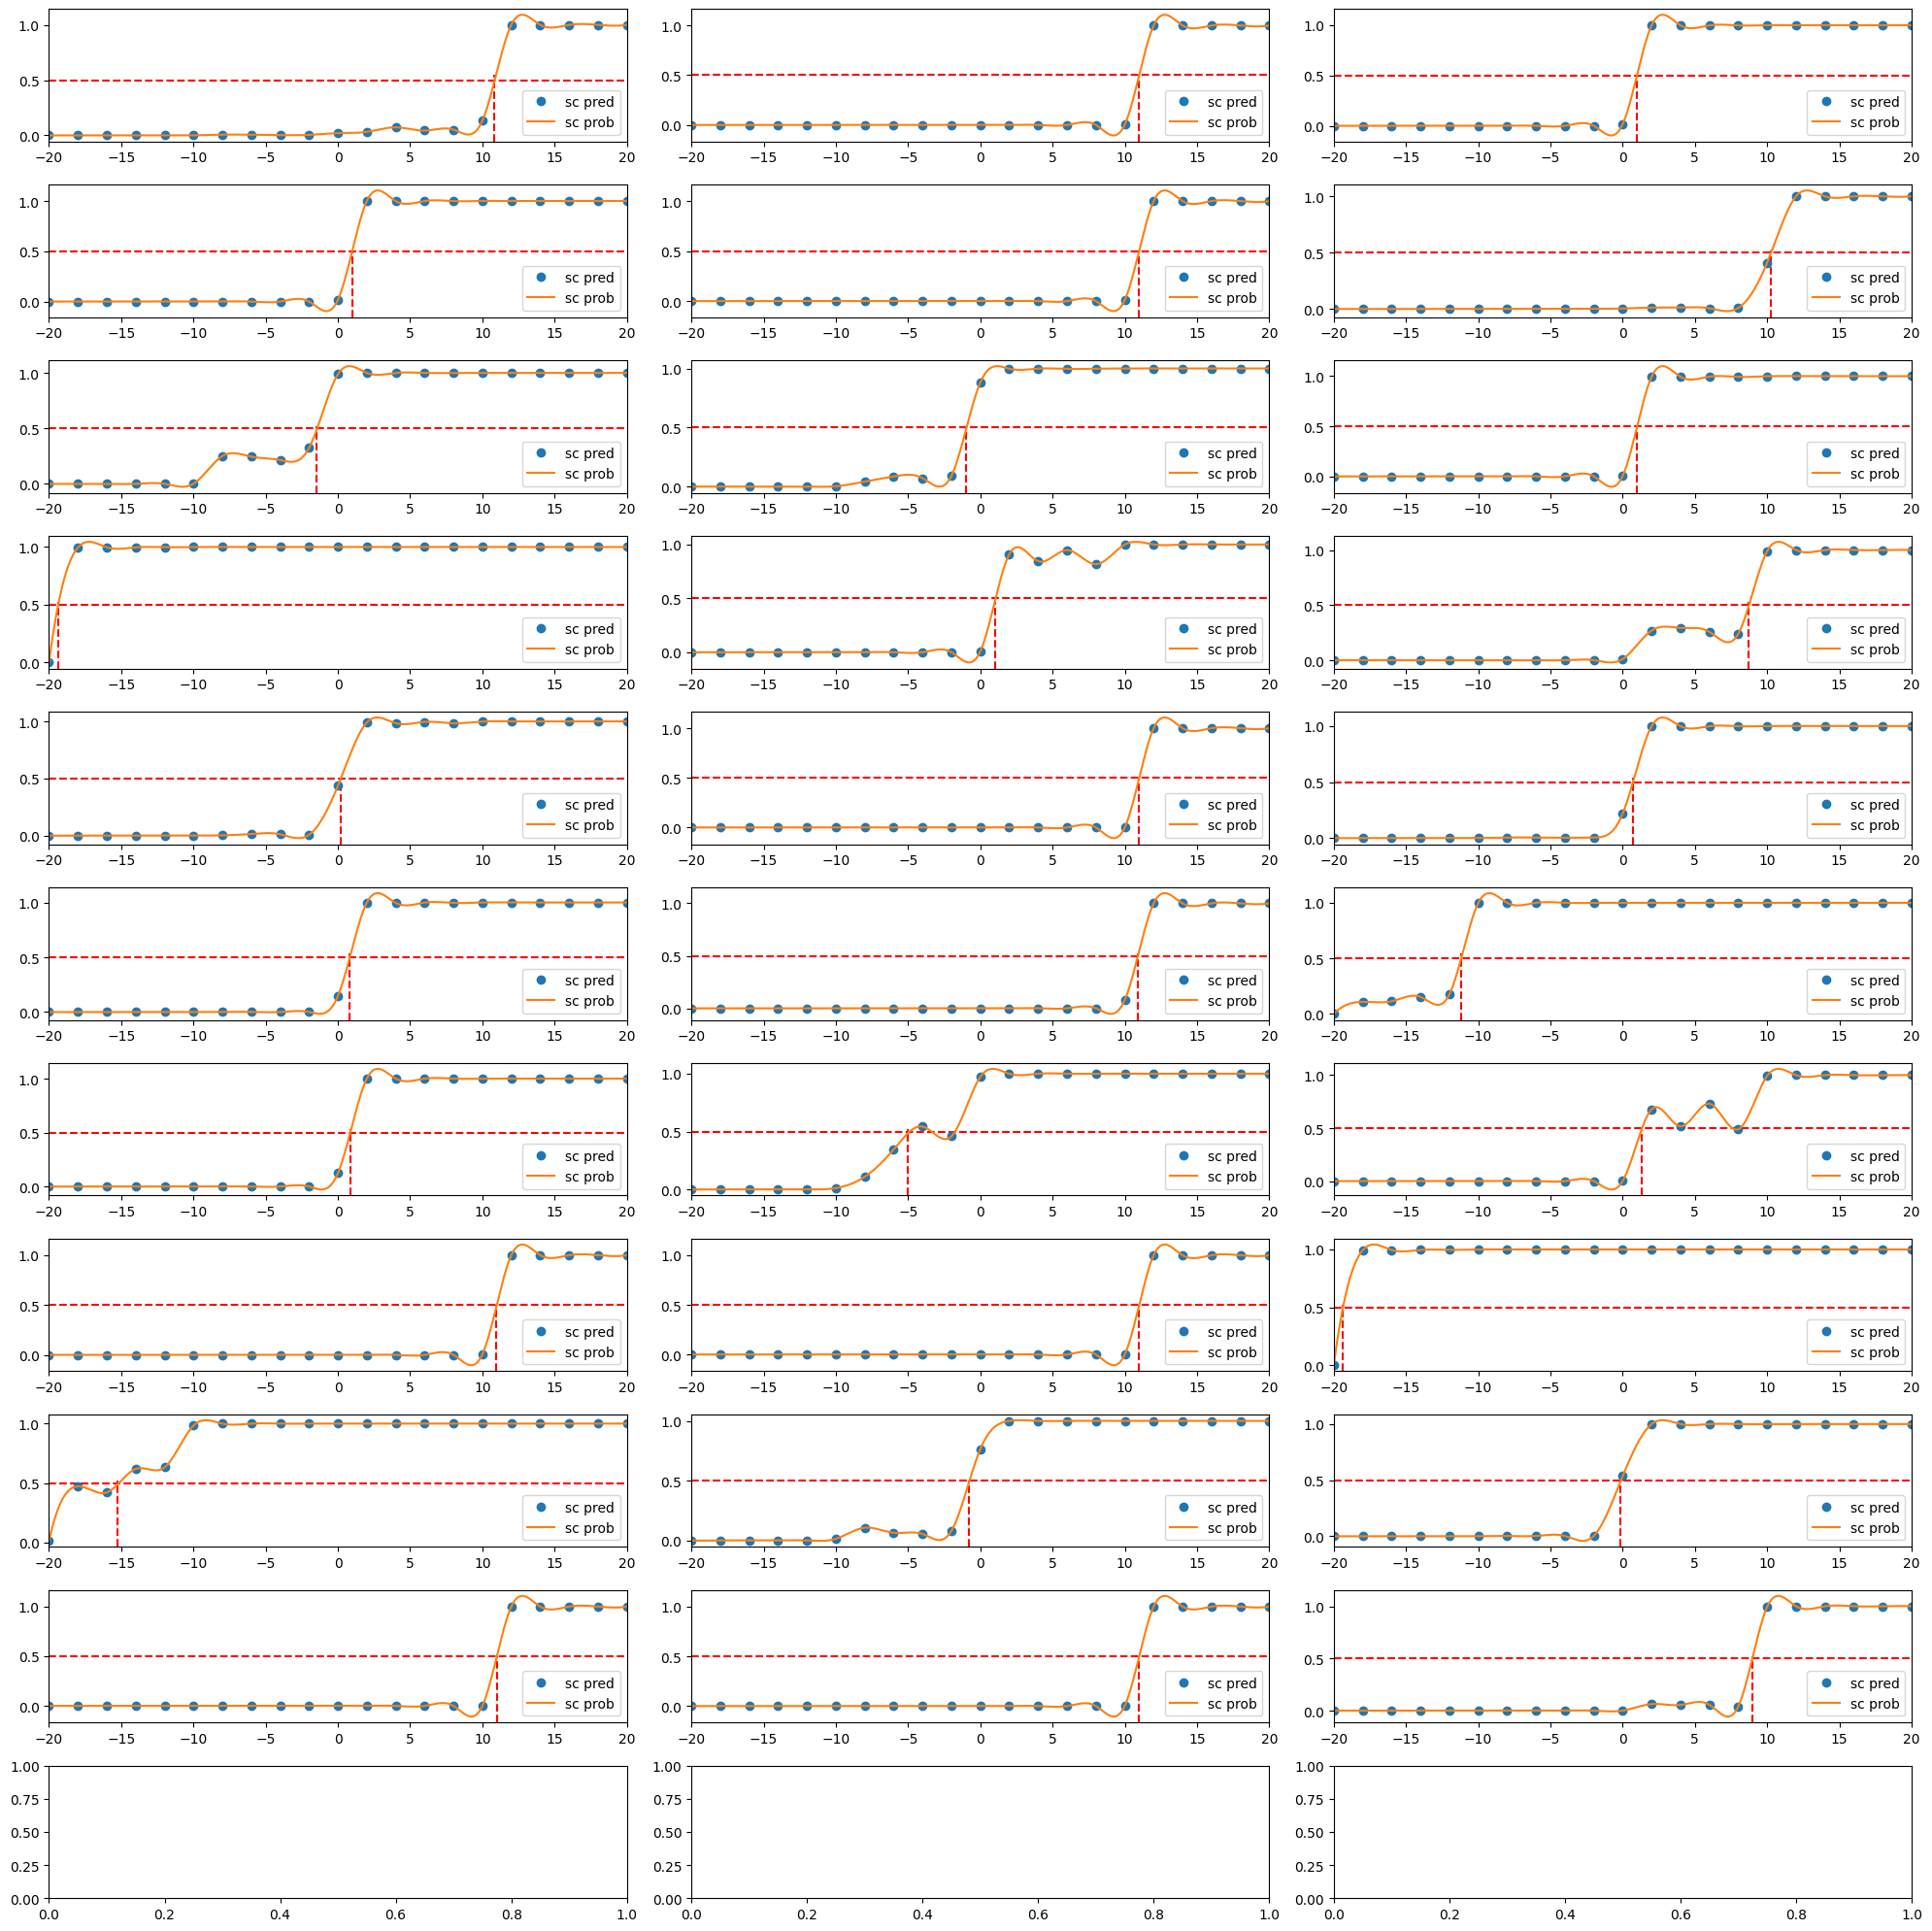

In [ ]:
fig, axes = plt.subplots(nrows=int(num_test_samples//3)+1, ncols=3, figsize=(20,20))
axes = axes.flatten();

wht_keys = [int(wht) for wht in wht_mapper.keys()]
wht_keys_interp_x = np.arange(wht_keys[0], wht_keys[-1], linspace_stride)
for i, supercritical_prob in enumerate(supercritical_probs):
    ax = axes[i]
    cs = CubicSpline(wht_keys, supercritical_prob)

    ax.axhline(y=0.5, color='r', linestyle='--')

    interp_y = cs(wht_keys_interp_x)
    half_x = (0.499 - linspace_stride < interp_y) & (cs(wht_keys_interp_x) < 0.501)
    half_x_indices = np.where(half_x)[0]
    if len(half_x_indices) > 0:
        ax.axvline(x=wht_keys_interp_x[half_x_indices[0]], ymax=0.5, color='r', linestyle='--')

    ax.plot(wht_keys, supercritical_prob, 'o', label='sc pred')
    ax.plot(wht_keys_interp_x, cs(wht_keys_interp_x), label='sc prob')
    ax.set_xlim(wht_keys[0], wht_keys[-1])
    ax.legend(loc='lower right')

plt.tight_layout()